In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
!ls drive/MyDrive/Dida_Project

535.png  539.png  553.png  labels	     Rooftop_segmentation.ipynb
537.png  551.png  images   Loss_and_IOU.png


In [54]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.nn.functional as F
import albumentations as A
import os
from PIL import Image
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(21)


In [55]:
img_path = "drive/MyDrive/Dida_Project/images"
mask_path = "drive/MyDrive/Dida_Project/labels"

In [56]:
#seperate indices for train and test images 
all_ind = [i.split(".")[0] for i in os.listdir(img_path)]
train_idx = [i.split(".")[0] for i in os.listdir(mask_path)]
test_idx = [i for i in all_ind if i not in train_idx]

In [57]:
#Compute image mean and stadard deviation for the train data and use the same for the test.
img_mean_t, img_std_t = [], []
for idx in train_idx:
    img = Image.open(os.path.join(img_path, idx + '.png')).convert('RGB')
    img = T.ToTensor()(img)
    img_mean_t.append(torch.mean(img, dim=(1, 2)))
    img_std_t.append(torch.std(img, dim=(1, 2)))
img_mean = torch.mean(torch.stack(img_mean_t), dim=0).tolist()
img_std = torch.mean(torch.stack(img_std_t), dim=0).tolist()

In [58]:

# for idx in train_idx[:3]:
#     img = Image.open(os.path.join(img_path, idx + '.png')).convert('RGB')
#     mask = Image.open(mask_path + "/" + idx + '.png').convert('L')


#     transform=A.Compose([A.HorizontalFlip(p= 0.5),A.VerticalFlip()])
#     aug = transform(image=np.array(img), mask=np.array(mask))
#     img = Image.fromarray(aug['image'])
#     mask = Image.fromarray(aug['mask'])

#     fig, ax = plt.subplots(1,2)

#     ax[0].imshow(mask)
#     ax[1].imshow(img)

In [59]:
class RoofDataset(Dataset):
    def __init__(self, img_path, mask_path, mode = "train", idx_list = None, transform = None):
      self.img_path =  img_path 
      self.mask_path = mask_path
      self.mode = mode
      self.idx_list = idx_list
      self.transform = transform
      self.img_mean = img_mean
      self.img_std = img_std
      
    def __len__(self):
        return len(self.idx_list)

    def __getitem__(self, idx):

        img = Image.open(self.img_path + "/"+self.idx_list[idx] + '.png').convert('RGB')

        if(self.mode == "train"): 
            mask = Image.open(self.mask_path + "/" + self.idx_list[idx] + '.png').convert('L')

        if (self.transform is not None) and (self.mode == "train"): # Use transformations only for the train images and mask. 
         
            aug = self.transform(image=np.array(img), mask=np.array(mask))
            img = Image.fromarray(aug['image'])
            mask = Image.fromarray(aug['mask'])
                

        # Convert the image to torch tensor and Normalize
        t = T.Compose([T.ToTensor(), T.Normalize(self.img_mean, self.img_std)])
        img = t(img)
        
        if(self.mode == "train"): # Convert the mask values to binary by thresholding with 0. 
            mask = torch.Tensor(np.array(mask))
            mask = mask > 0
            mask = mask.long() 
        else:
            mask = torch.tensor([])            
        return img, mask


In [60]:
train_transform=A.Compose([A.HorizontalFlip(),A.VerticalFlip()])
#Define the train and test datasets
train_set = RoofDataset(img_path, mask_path,"train", train_idx,train_transform)
# train_set = RoofDataset(img_path, mask_path,"train", train_idx)
test_set = RoofDataset(img_path, mask_path, "test",test_idx)

#define train and test dataloader
batch_size= 4 
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=len(test_idx), shuffle=False) 


In [61]:

class UNet(nn.Module):
    def __init__(self, encoder_name='resnet34', encoder_weights='imagenet',
                 in_channels=3, classes=2, freeze = 2):
        super().__init__()
        # Utilizing the pytorch segmentation models
        self.model = smp.Unet(encoder_name=encoder_name,
                              encoder_weights=encoder_weights,
                              in_channels=in_channels,
                              classes=classes)
        # Freeze the initial layers to preserve the basic learnings
        if freeze is not None:
            for name, param in self.model.encoder.named_parameters():
                for layer in np.arange(freeze):
                    if name.startswith(str(layer)):
                        param.requires_grad = False

    def forward(self, x):
        return self.model(x)

In [62]:
def get_iou(output,target):
    #Compute intersection over union
    intersection = torch.logical_and(output, target).sum().float().item()
    union = torch.logical_or(output, target).sum().float().item()
    iou = (intersection) / (union )
    return iou

In [63]:
def train_test( model, data_loader, criterion, optimizer, scheduler,mode = "train"):
    ''' Common loop function for train and test loop. 
    '''
    torch.cuda.empty_cache()
    lrs = []
    tot_loss = 0
    tot_iou = 0
    pred_mask_list = []
    mask_list =[]
    if(mode == "train"):
        model.train()
    else:
        model.eval()
    for i, data in enumerate(data_loader):

        image, mask = data
        image = image.to(device); mask = mask.to(device);
        #forward 
        output = model(image)
        # Convert the output into mask with binary labels 
        pred_mask = torch.argmax(output, dim=1)
        pred_mask = pred_mask.cpu().squeeze(0)
        pred_mask_list.append(pred_mask)
        mask_list.append(mask)
        if(mode == "train"):
            # Compute gradients loss and IOU only for the train set. 
            optimizer.zero_grad() #reset gradient
            loss = criterion(output, mask)
            iou = get_iou(pred_mask, mask)
            tot_loss += loss.item()
            tot_iou += iou
            #backward
            loss.backward()
            optimizer.step() #update weight          
            
            #step the learning rate
            scheduler.step() 
            

    tot_loss = tot_loss/len(data_loader)  

    if(mode == "train"):
        return  model, tot_loss, tot_iou, pred_mask_list, mask_list

    return pred_mask_list, mask_list

In [64]:

base_lr = 1e-3
epochs = 18
weight_decay = 1e-4


criterion = nn.CrossEntropyLoss()
# The desired parameters can be adjusted for the model as shown in the commented block
# model = UNet(encoder_name='resnet34', encoder_weights='imagenet',
#                  in_channels=3, classes=2)
model = UNet(freeze = 3)
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # ExponentialLR to adjust the lr, lr_(t+1) = lr_(t) * gamma

train_losses = []
train_iou = []
pred_masks  = []
for epoch in range(epochs):
    model, loss, iou, pred_mask_list, mask_list = train_test( model, train_loader, criterion, optimizer, scheduler,mode = "train")
    train_losses.append(loss)
    train_iou.append(iou)
    pred_masks.append(pred_mask_list)
    print("Epoch:{}/{},  ".format(epoch+1, epochs),
          "Train loss:{} ".format(round(loss,4)))

Epoch:1/18,   Train loss:0.583 
Epoch:2/18,   Train loss:0.4105 
Epoch:3/18,   Train loss:0.3195 
Epoch:4/18,   Train loss:0.2821 
Epoch:5/18,   Train loss:0.338 
Epoch:6/18,   Train loss:0.2384 
Epoch:7/18,   Train loss:0.2346 
Epoch:8/18,   Train loss:0.2165 
Epoch:9/18,   Train loss:0.219 
Epoch:10/18,   Train loss:0.2053 
Epoch:11/18,   Train loss:0.1997 
Epoch:12/18,   Train loss:0.1989 
Epoch:13/18,   Train loss:0.1906 
Epoch:14/18,   Train loss:0.1966 
Epoch:15/18,   Train loss:0.1928 
Epoch:16/18,   Train loss:0.1919 
Epoch:17/18,   Train loss:0.2008 
Epoch:18/18,   Train loss:0.1964 


In [65]:
pred_mask_test, mask_test = train_test( model,test_loader, criterion, optimizer, scheduler,mode = "test")

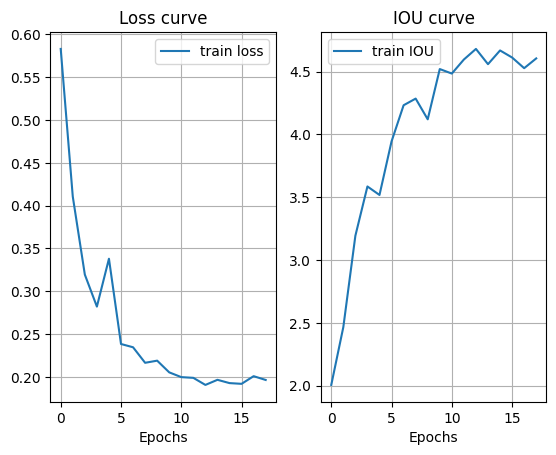

In [66]:
# Visualizing the loss and IOU curves
fig,ax = plt.subplots(1,2)
ax[0].plot(np.arange(epochs), train_losses, label = "train loss")
ax[1].plot(np.arange(epochs), train_iou, label = "train IOU")
ax[0].set_title("Loss curve")
ax[1].set_title("IOU curve")
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel("Epochs")
ax[1].set_xlabel("Epochs")
ax[0].grid()
ax[1].grid()
fig.savefig("drive/MyDrive/Dida_Project/" + "Loss_and_IOU.png")

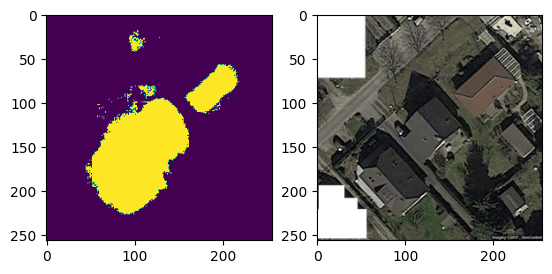

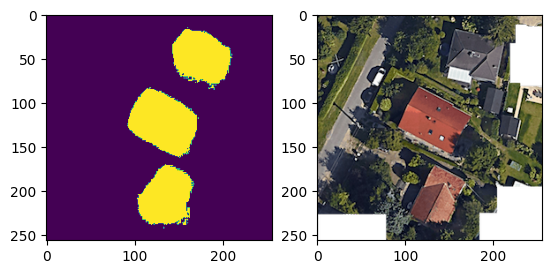

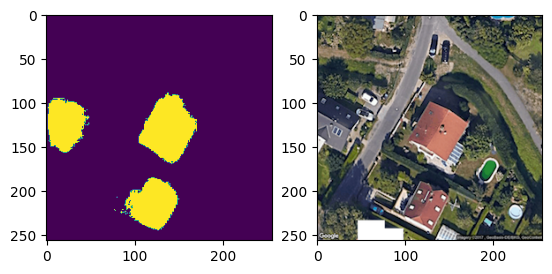

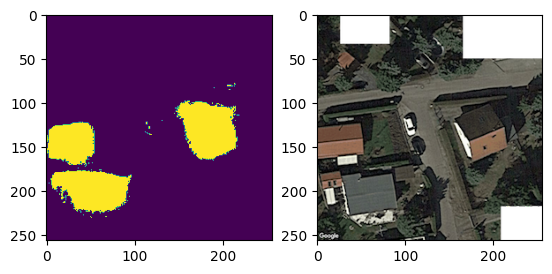

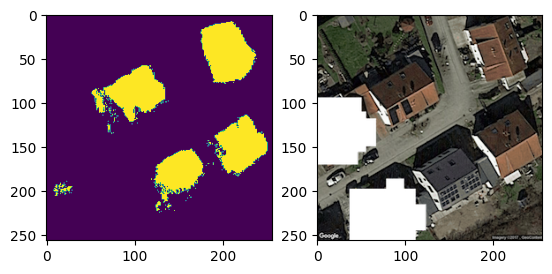

In [67]:
# Visualizing results on the test data
for i,idx in enumerate(test_idx):
    fig, ax = plt.subplots(1,2)
    img = Image.open(img_path + "/"+idx + '.png')
    ax[0].imshow(pred_mask_test[0][i])
    ax[1].imshow(img)
    fig.savefig("drive/MyDrive/Dida_Project/" + idx + ".png")